In [1]:
from potential_initialization import *
from shuttling import *
%load_ext autoreload
%autoreload 2

In [2]:
pbi, ppi = dict(), dict()

In [3]:

shuttle_range = [[-1, 1], [-0.1, 0.1], [0.05, 0.1]]
junction = trap_model("junction", shuttle_range, pbi, ppi)

100%|██████████| 400/400 [00:01<00:00, 399.95it/s]


  0%|          | 0/50 [00:00<?, ?it/s]d:\Workplace\PythonScripts\surface trap electrostatic field\shuttling.py:178: RuntimeWarning: invalid value encountered in sqrt
  omega = (np.array([hessian[0, 0], hessian[1, 1], hessian[2, 2]]) / 1e6 * q / m) ** 0.5 / (2 * np.pi)
 48%|████▊     | 24/50 [00:23<00:25,  1.01it/s]d:\Anaconda\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
100%|██████████| 50/50 [00:51<00:00,  1.04s/it]


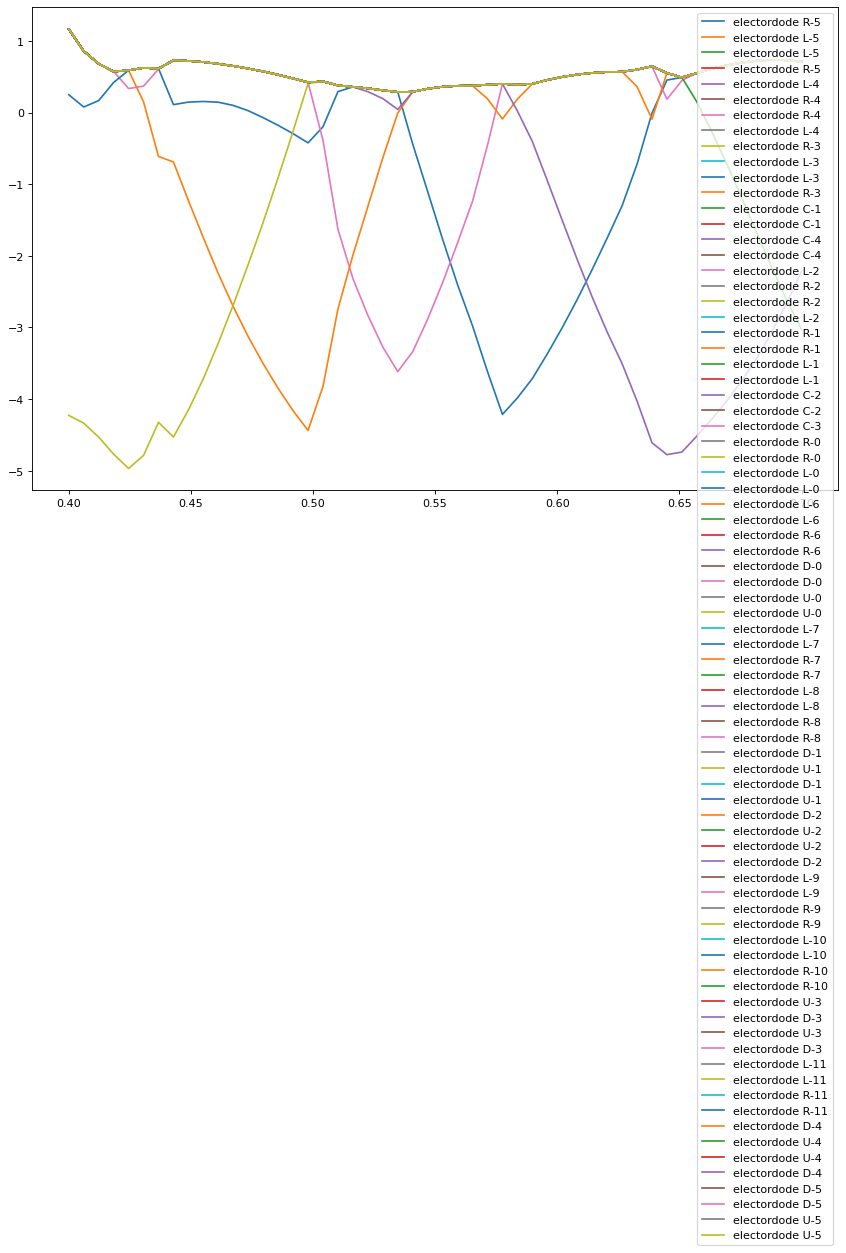

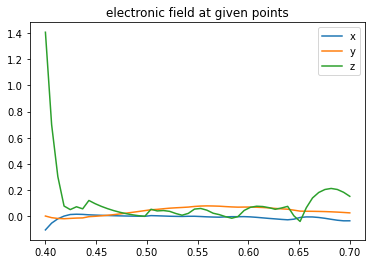

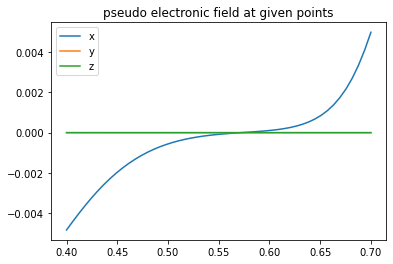

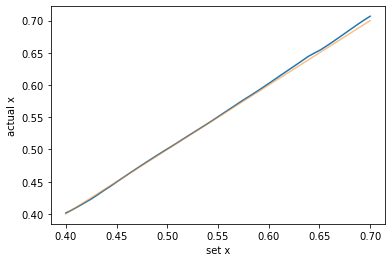

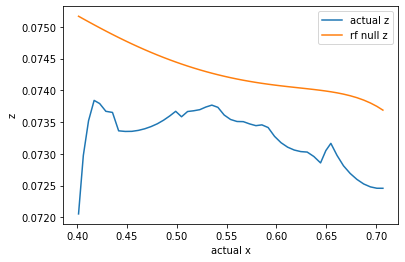

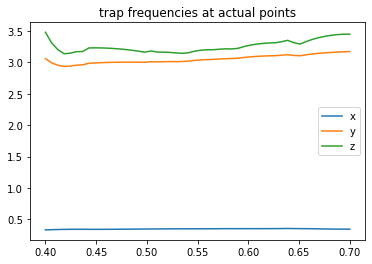

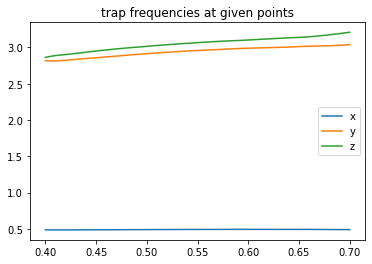

In [14]:
%matplotlib inline
profile = np.linspace(0.4, 0.7, 50)
voltages, grads, frequencies, psEs, positions \
    = junction.optimized_voltage_profile(profile, top_nearest=5, alpha=200, w=[0, 1000, 0, 100, 100, 1, 1, 0.5, 0.5, 0],\
                                              omega=[0.5, 3, 3], confine_voltage=0, max_voltage=10, calc_position=True, compensate_z=True)

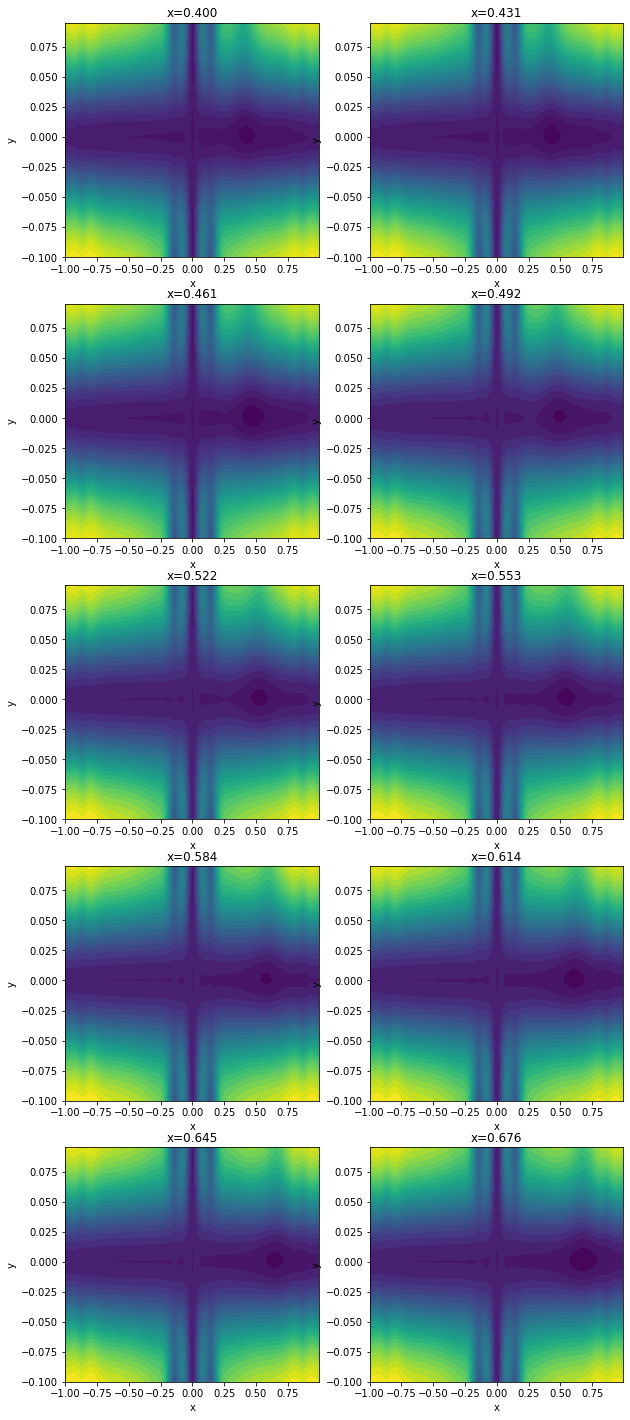

In [13]:

fig, ax = plt.subplots(5, 2, figsize=(10, 25))
cnt = 0
ax = ax.reshape(ax.size)
for i, opt in enumerate(voltages):
    if i % 5 == 0:
        junction.plot_slice(opt, z=positions[i, 2], ax=ax[cnt])
        ax[cnt].set_title('x=%.3f' % profile[i])
        # ax[cnt].set_xlabel("x")
        cnt += 1

In [ ]:
%matplotlib inline



for cv in [3, 4, 5, 6]:
        frequencies = []
        for x in np.linspace(0.3, 0.8, 50):

                indices = junction.get_indices(use_sectors=None, point=junction.rf_null_point(x), top_nearest=10, plot=False)
                [junction.idx2sector[i] for i in indices]

                voltage = np.ones(94) * cv
                voltage[indices] = 0

                point = junction.rf_null_point(x)

                frequencies.append(junction.freq(point, voltage))

        frequencies = np.array(frequencies)

        plt.plot(np.linspace(0.3, 0.8, 50), frequencies[:, 0], label="x direction ")
        plt.plot(np.linspace(0.3, 0.8, 50), frequencies[:, 1], label="y direction ")
        plt.plot(np.linspace(0.3, 0.8, 50), frequencies[:, 2], label="z direction ")
        plt.xlabel("x")
        plt.ylabel("trap frequency(MHz)")
        plt.legend()
        plt.title("confine voltage=%.2f" % cv)
        plt.show()


In [ ]:
from scipy.optimize import minimize

def trap_frequency(location, hess):
    hessian = np.array(hess(location))
    eig, eigv = np.linalg.eig(hessian)
    return (q * eig * 1e-6 / m) ** 0.5 / (2 * np.pi)  , eigv

ion_location = minimize(junction.pseudo_interp, [0.6, 0, 0.07], bounds=shuttle_range, jac=junction.pseudo_jac, tol=1e-6).x
# ion_location = np.array([0.6, 0, 0.074])
freq, direction = trap_frequency(ion_location, junction.pseudo_hess)
(freq / np.array([0.0110397, 3.06111, 3.15968]) ) 
# ion_location

array([0.77104912, 1.00231415, 0.96974018])

In [ ]:
q = 1.6e-19
m = 0.171/6.02e23
hessian = np.array(junction.pseudo_hess((ion_location)))
eig = np.array([hessian[0, 0], hessian[1, 1], hessian[2, 2]])
freq = (q * eig * 1e-6 / m) ** 0.5 / (2 * np.pi )
(freq / np.array([0.0110397, 3.06111, 3.15968]) )

array([0.94069967, 1.00096653, 0.97104393])

In [ ]:
junction.pseudo_interp([0.6, 0, 0.074]) * 1e6

array([-0.24923488], dtype=float64)

1. 带入算surface trap
2. 电极配对
3. 研究一下split

1. 设计大家都能调的接口
   1. 确定能被调用的电极
   2. 确定不能够调用的电极，并指定它们的电压，如果没有指定，则设为0
   3. 运动过程中用的电极是否变化
2. 如果1做不到，那就尝试自己调
3. 把surface小三角形变稀疏，根据pseudo potential的长相确定场点范围